In [6]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import pyfolio as pf
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [28]:
class TestStrategy(bt.Strategy):
    
    params = dict(profit_percent=0.3, loss_percent = 0.2, efast = 10, eslow=30)
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        tm = self.datas[0].datetime.time(0)
        print('%s, %s,  %s' % (dt.isoformat(), tm.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.price = None
        self.comm = None
        emafast = bt.ind.EMA(period=self.p.efast)
        emaslow = bt.ind.EMA(period=self.p.eslow)
        self.crossover = bt.ind.CrossOver(emafast,emaslow)
        
    def notify_order(self, order):
        date = self.data.datetime.datetime().date()
        
        if order.status in [order.Submitted, order.Accepted]:
            return
            
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.price = order.executed.price
                self.comm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order Margin/Rejected')
        
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
            #Closing Bracket orders comes under this condition

        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
                 
    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:
            #Check the order while placing the amounts for different types, limit order and to do functions
            #like find a breakout and confirm the indicator. Many a times generates errors
            if self.crossover>0:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                entry = self.dataclose
                self.order = self.buy_bracket(limitprice=entry*(1+(self.p.profit_percent/100)),
                                              stopprice=entry*(1-(self.p.loss_percent/100)),
                                              exectype=bt.Order.Market)

        #Uncomment this and find that it is buying and selling way too frequently.
        #The behavior can be observed from the plot but no explanation
        else:
            if self.crossover<0:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                entry = self.dataclose
                self.order = self.sell_bracket(limitprice=entry*(1-(self.p.profit_percent/100)),
                                              stopprice=entry*(1+(self.p.loss_percent/100)),
                                              exectype=bt.Order.Market)

        

In [29]:
#A function for properly processing and printing analyzers
def printTradeAnalysis(analyzer):
    
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("\n\nTrade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

In [30]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    #modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    #datapath = os.path.join(modpath, 'datas/orcl-1995-2014.txt')
    dirpath = os.path.dirname('/home/aviral/Desktop/Algo_trading_iitk/')
    datapath = os.path.join(dirpath, 'Nifty_2013.csv')

    #Check the format and positions of the datafeeds in case another file is used
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        
        fromdate=datetime.datetime(2015, 1, 1),
        todate=datetime.datetime(2015, 12, 31),
        nullvalue = 0.0,
        
        dtformat = ('%d/%m/%Y'),
        tmformat = ('%H:%M:%S'),
        
        timeframe = bt.TimeFrame.Minutes,
        compression = 1,
        #Compression is useful if the data is per minute but we want to use 5 min intervals
        
        #Keeping a 15 minute buffer time before the start of the day and before the market closes
        #sessionstart = datetime.time('09:30:00'),
        #sessionend = datetime.time('15:15:00'),
        
        datetime = 0,
        time = 1,
        open = 2,
        high = 3,
        low = 4,
        close = 5,
        volume = 6,
        openinterest = -1,
        reverse=False)

    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)

    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    cerebro.broker.setcommission(commission=0.001)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    strats = cerebro.run()
    printTradeAnalysis(strats[0].analyzers.ta.get_analysis())

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
2015-01-01, 10:38:00,  BUY CREATE, 8315.15
2015-01-01, 10:39:00,  BUY EXECUTED, Price: 8315.15, Cost: 83151.50, Comm 83.15
2015-01-01, 10:44:00,  SELL CREATE, 8313.90
2015-01-01, 10:45:00,  Order Margin/Rejected
2015-01-01, 10:45:00,  Order Canceled
2015-01-01, 10:45:00,  Order Canceled
2015-01-01, 12:19:00,  SELL CREATE, 8323.70
2015-01-01, 12:20:00,  Order Margin/Rejected
2015-01-01, 12:20:00,  Order Canceled
2015-01-01, 12:20:00,  Order Canceled
2015-01-01, 12:57:00,  SELL CREATE, 8319.50
2015-01-01, 12:58:00,  Order Margin/Rejected
2015-01-01, 12:58:00,  Order Canceled
2015-01-01, 12:58:00,  Order Canceled
2015-01-01, 13:00:00,  SELL CREATE, 8320.15
2015-01-01, 13:01:00,  Order Margin/Rejected
2015-01-01, 13:01:00,  Order Canceled
2015-01-01, 13:01:00,  Order Canceled
2015-01-01, 14:33:00,  SELL EXECUTED, Price: 8340.10, Cost: 83151.50, Comm 83.40
2015-01-01, 14:33:00,  Order Canceled
2015-01-01, 14:33:00,  OPERATION PROFIT, GROSS 249.45, NET 82.

2015-01-08, 10:52:00,  BUY CREATE, 8213.50
2015-01-08, 10:53:00,  BUY EXECUTED, Price: 8213.50, Cost: 82135.00, Comm 82.14
2015-01-08, 11:23:00,  SELL CREATE, 8214.05
2015-01-08, 11:24:00,  Order Margin/Rejected
2015-01-08, 11:24:00,  Order Canceled
2015-01-08, 11:24:00,  Order Canceled
2015-01-08, 12:43:00,  SELL CREATE, 8217.00
2015-01-08, 12:44:00,  Order Margin/Rejected
2015-01-08, 12:44:00,  Order Canceled
2015-01-08, 12:44:00,  Order Canceled
2015-01-08, 13:13:00,  SELL CREATE, 8217.35
2015-01-08, 13:14:00,  Order Margin/Rejected
2015-01-08, 13:14:00,  Order Canceled
2015-01-08, 13:14:00,  Order Canceled
2015-01-08, 13:57:00,  SELL EXECUTED, Price: 8238.14, Cost: 82135.00, Comm 82.38
2015-01-08, 13:57:00,  Order Canceled
2015-01-08, 13:57:00,  OPERATION PROFIT, GROSS 246.40, NET 81.89
2015-01-09, 09:16:00,  BUY CREATE, 8309.90
2015-01-09, 09:17:00,  BUY EXECUTED, Price: 8309.90, Cost: 83099.00, Comm 83.10
2015-01-09, 09:51:00,  SELL EXECUTED, Price: 8293.28, Cost: 83099.00, Comm 

2015-01-15, 14:04:00,  BUY CREATE, 8514.70
2015-01-15, 14:05:00,  BUY EXECUTED, Price: 8514.70, Cost: 85147.00, Comm 85.15
2015-01-15, 14:34:00,  SELL EXECUTED, Price: 8540.24, Cost: 85147.00, Comm 85.40
2015-01-15, 14:34:00,  Order Canceled
2015-01-15, 14:34:00,  OPERATION PROFIT, GROSS 255.44, NET 84.89
2015-01-16, 09:46:00,  BUY CREATE, 8501.05
2015-01-16, 09:47:00,  BUY EXECUTED, Price: 8501.05, Cost: 85010.50, Comm 85.01
2015-01-16, 11:00:00,  SELL CREATE, 8508.30
2015-01-16, 11:01:00,  Order Margin/Rejected
2015-01-16, 11:01:00,  Order Canceled
2015-01-16, 11:01:00,  Order Canceled
2015-01-16, 11:35:00,  SELL EXECUTED, Price: 8526.55, Cost: 85010.50, Comm 85.27
2015-01-16, 11:35:00,  Order Canceled
2015-01-16, 11:35:00,  OPERATION PROFIT, GROSS 255.03, NET 84.76
2015-01-16, 12:22:00,  BUY CREATE, 8515.55
2015-01-16, 12:23:00,  BUY EXECUTED, Price: 8515.55, Cost: 85155.50, Comm 85.16
2015-01-16, 13:09:00,  SELL CREATE, 8523.95
2015-01-16, 13:10:00,  Order Margin/Rejected
2015-01-1

2015-01-28, 11:08:00,  SELL EXECUTED, Price: 8936.73, Cost: 89100.00, Comm 89.37
2015-01-28, 11:08:00,  Order Canceled
2015-01-28, 11:08:00,  OPERATION PROFIT, GROSS 267.30, NET 88.83
2015-01-28, 14:06:00,  BUY CREATE, 8914.00
2015-01-28, 14:07:00,  BUY EXECUTED, Price: 8914.00, Cost: 89140.00, Comm 89.14
2015-01-28, 14:16:00,  SELL CREATE, 8904.00
2015-01-28, 14:17:00,  Order Margin/Rejected
2015-01-28, 14:17:00,  Order Canceled
2015-01-28, 14:17:00,  Order Canceled
2015-01-28, 14:19:00,  SELL EXECUTED, Price: 8896.17, Cost: 89140.00, Comm 88.96
2015-01-28, 14:19:00,  Order Canceled
2015-01-28, 14:19:00,  OPERATION PROFIT, GROSS -178.28, NET -356.38
2015-01-28, 14:54:00,  BUY CREATE, 8895.00
2015-01-28, 14:55:00,  BUY EXECUTED, Price: 8895.00, Cost: 88950.00, Comm 88.95
2015-01-29, 09:16:00,  SELL EXECUTED, Price: 8877.21, Cost: 88950.00, Comm 88.77
2015-01-29, 09:16:00,  Order Canceled
2015-01-29, 09:16:00,  OPERATION PROFIT, GROSS -177.90, NET -355.62
2015-01-29, 09:54:00,  BUY CREA

2015-02-04, 10:39:00,  BUY CREATE, 8807.00
2015-02-04, 10:40:00,  BUY EXECUTED, Price: 8807.00, Cost: 88070.00, Comm 88.07
2015-02-04, 10:41:00,  SELL CREATE, 8798.00
2015-02-04, 10:42:00,  Order Margin/Rejected
2015-02-04, 10:42:00,  Order Canceled
2015-02-04, 10:42:00,  Order Canceled
2015-02-04, 10:44:00,  SELL EXECUTED, Price: 8789.39, Cost: 88070.00, Comm 87.89
2015-02-04, 10:44:00,  Order Canceled
2015-02-04, 10:44:00,  OPERATION PROFIT, GROSS -176.14, NET -352.10
2015-02-04, 11:06:00,  BUY CREATE, 8802.00
2015-02-04, 11:07:00,  BUY EXECUTED, Price: 8802.00, Cost: 88020.00, Comm 88.02
2015-02-04, 11:43:00,  SELL CREATE, 8802.50
2015-02-04, 11:44:00,  Order Margin/Rejected
2015-02-04, 11:44:00,  Order Canceled
2015-02-04, 11:44:00,  Order Canceled
2015-02-04, 12:08:00,  SELL CREATE, 8800.15
2015-02-04, 12:09:00,  Order Margin/Rejected
2015-02-04, 12:09:00,  Order Canceled
2015-02-04, 12:09:00,  Order Canceled
2015-02-04, 12:31:00,  SELL CREATE, 8793.50
2015-02-04, 12:32:00,  Order

2015-02-11, 15:01:00,  SELL CREATE, 8672.30
2015-02-11, 15:02:00,  Order Margin/Rejected
2015-02-11, 15:02:00,  Order Canceled
2015-02-11, 15:02:00,  Order Canceled
2015-02-12, 09:16:00,  SELL EXECUTED, Price: 8720.00, Cost: 86721.00, Comm 87.20
2015-02-12, 09:16:00,  Order Canceled
2015-02-12, 09:16:00,  OPERATION PROFIT, GROSS 479.00, NET 305.08
2015-02-12, 09:59:00,  BUY CREATE, 8678.60
2015-02-12, 10:00:00,  BUY EXECUTED, Price: 8678.60, Cost: 86786.00, Comm 86.79
2015-02-12, 10:10:00,  SELL CREATE, 8664.00
2015-02-12, 10:11:00,  Order Margin/Rejected
2015-02-12, 10:11:00,  Order Canceled
2015-02-12, 10:11:00,  Order Canceled
2015-02-12, 10:11:00,  SELL EXECUTED, Price: 8661.24, Cost: 86786.00, Comm 86.61
2015-02-12, 10:11:00,  Order Canceled
2015-02-12, 10:11:00,  OPERATION PROFIT, GROSS -173.57, NET -346.97
2015-02-12, 10:54:00,  BUY CREATE, 8663.90
2015-02-12, 10:55:00,  BUY EXECUTED, Price: 8663.90, Cost: 86639.00, Comm 86.64
2015-02-12, 11:16:00,  SELL CREATE, 8661.00
2015-02-

2015-02-25, 10:26:00,  BUY CREATE, 8826.75
2015-02-25, 10:27:00,  Order Margin/Rejected
2015-02-25, 10:27:00,  Order Margin/Rejected
2015-02-25, 10:27:00,  Order Margin/Rejected
2015-02-25, 11:14:00,  BUY CREATE, 8821.50
2015-02-25, 11:15:00,  Order Margin/Rejected
2015-02-25, 11:15:00,  Order Margin/Rejected
2015-02-25, 11:15:00,  Order Margin/Rejected
2015-02-25, 12:18:00,  BUY CREATE, 8831.00
2015-02-25, 12:19:00,  Order Margin/Rejected
2015-02-25, 12:19:00,  Order Margin/Rejected
2015-02-25, 12:19:00,  Order Margin/Rejected
2015-02-25, 12:47:00,  BUY CREATE, 8829.00
2015-02-25, 12:48:00,  Order Margin/Rejected
2015-02-25, 12:48:00,  Order Margin/Rejected
2015-02-25, 12:48:00,  Order Margin/Rejected
2015-02-25, 13:37:00,  BUY CREATE, 8824.50
2015-02-25, 13:38:00,  Order Margin/Rejected
2015-02-25, 13:38:00,  Order Margin/Rejected
2015-02-25, 13:38:00,  Order Margin/Rejected
2015-02-25, 15:15:00,  BUY CREATE, 8772.30
2015-02-25, 15:16:00,  Order Margin/Rejected
2015-02-25, 15:16:00, 

2015-03-09, 12:14:00,  BUY CREATE, 8847.50
2015-03-09, 12:15:00,  Order Margin/Rejected
2015-03-09, 12:15:00,  Order Margin/Rejected
2015-03-09, 12:15:00,  Order Margin/Rejected
2015-03-09, 12:57:00,  BUY CREATE, 8851.00
2015-03-09, 12:58:00,  Order Margin/Rejected
2015-03-09, 12:58:00,  Order Margin/Rejected
2015-03-09, 12:58:00,  Order Margin/Rejected
2015-03-09, 13:59:00,  BUY CREATE, 8817.00
2015-03-09, 14:00:00,  Order Margin/Rejected
2015-03-09, 14:00:00,  Order Margin/Rejected
2015-03-09, 14:00:00,  Order Margin/Rejected
2015-03-09, 14:33:00,  BUY CREATE, 8816.00
2015-03-09, 14:34:00,  Order Margin/Rejected
2015-03-09, 14:34:00,  Order Margin/Rejected
2015-03-09, 14:34:00,  Order Margin/Rejected
2015-03-10, 09:32:00,  BUY CREATE, 8790.75
2015-03-10, 09:33:00,  Order Margin/Rejected
2015-03-10, 09:33:00,  Order Margin/Rejected
2015-03-10, 09:33:00,  Order Margin/Rejected
2015-03-10, 09:44:00,  BUY CREATE, 8787.85
2015-03-10, 09:45:00,  Order Margin/Rejected
2015-03-10, 09:45:00, 

2015-03-16, 14:25:00,  Order Margin/Rejected
2015-03-16, 15:20:00,  BUY CREATE, 8669.15
2015-03-16, 15:21:00,  Order Margin/Rejected
2015-03-16, 15:21:00,  Order Margin/Rejected
2015-03-16, 15:21:00,  Order Margin/Rejected
2015-03-17, 10:55:00,  BUY CREATE, 8743.65
2015-03-17, 10:56:00,  Order Margin/Rejected
2015-03-17, 10:56:00,  Order Margin/Rejected
2015-03-17, 10:56:00,  Order Margin/Rejected
2015-03-17, 13:34:00,  BUY CREATE, 8681.00
2015-03-17, 13:35:00,  Order Margin/Rejected
2015-03-17, 13:35:00,  Order Margin/Rejected
2015-03-17, 13:35:00,  Order Margin/Rejected
2015-03-17, 14:03:00,  BUY CREATE, 8666.65
2015-03-17, 14:04:00,  Order Margin/Rejected
2015-03-17, 14:04:00,  Order Margin/Rejected
2015-03-17, 14:04:00,  Order Margin/Rejected
2015-03-17, 14:24:00,  BUY CREATE, 8670.40
2015-03-17, 14:25:00,  Order Margin/Rejected
2015-03-17, 14:25:00,  Order Margin/Rejected
2015-03-17, 14:25:00,  Order Margin/Rejected
2015-03-17, 14:43:00,  BUY CREATE, 8670.50
2015-03-17, 14:44:00, 

2015-03-30, 11:27:00,  BUY CREATE, 8479.95
2015-03-30, 11:28:00,  Order Margin/Rejected
2015-03-30, 11:28:00,  Order Margin/Rejected
2015-03-30, 11:28:00,  Order Margin/Rejected
2015-03-30, 12:04:00,  BUY CREATE, 8471.80
2015-03-30, 12:05:00,  Order Margin/Rejected
2015-03-30, 12:05:00,  Order Margin/Rejected
2015-03-30, 12:05:00,  Order Margin/Rejected
2015-03-30, 12:24:00,  BUY CREATE, 8472.05
2015-03-30, 12:25:00,  Order Margin/Rejected
2015-03-30, 12:25:00,  Order Margin/Rejected
2015-03-30, 12:25:00,  Order Margin/Rejected
2015-03-30, 14:12:00,  BUY CREATE, 8523.95
2015-03-30, 14:13:00,  Order Margin/Rejected
2015-03-30, 14:13:00,  Order Margin/Rejected
2015-03-30, 14:13:00,  Order Margin/Rejected
2015-03-30, 14:42:00,  BUY CREATE, 8539.25
2015-03-30, 14:43:00,  Order Margin/Rejected
2015-03-30, 14:43:00,  Order Margin/Rejected
2015-03-30, 14:43:00,  Order Margin/Rejected
2015-03-31, 10:33:00,  BUY CREATE, 8569.55
2015-03-31, 10:34:00,  Order Margin/Rejected
2015-03-31, 10:34:00, 

2015-04-15, 11:00:00,  BUY CREATE, 8849.90
2015-04-15, 11:01:00,  Order Margin/Rejected
2015-04-15, 11:01:00,  Order Margin/Rejected
2015-04-15, 11:01:00,  Order Margin/Rejected
2015-04-15, 11:58:00,  BUY CREATE, 8845.00
2015-04-15, 11:59:00,  Order Margin/Rejected
2015-04-15, 11:59:00,  Order Margin/Rejected
2015-04-15, 11:59:00,  Order Margin/Rejected
2015-04-15, 12:31:00,  BUY CREATE, 8850.00
2015-04-15, 12:32:00,  Order Margin/Rejected
2015-04-15, 12:32:00,  Order Margin/Rejected
2015-04-15, 12:32:00,  Order Margin/Rejected
2015-04-15, 13:11:00,  BUY CREATE, 8853.85
2015-04-15, 13:12:00,  Order Margin/Rejected
2015-04-15, 13:12:00,  Order Margin/Rejected
2015-04-15, 13:12:00,  Order Margin/Rejected
2015-04-15, 13:32:00,  BUY CREATE, 8851.80
2015-04-15, 13:33:00,  Order Margin/Rejected
2015-04-15, 13:33:00,  Order Margin/Rejected
2015-04-15, 13:33:00,  Order Margin/Rejected
2015-04-15, 13:44:00,  BUY CREATE, 8852.40
2015-04-15, 13:45:00,  Order Margin/Rejected
2015-04-15, 13:45:00, 

2015-04-28, 12:22:00,  BUY CREATE, 8230.00
2015-04-28, 12:23:00,  BUY EXECUTED, Price: 8229.95, Cost: 82299.50, Comm 82.30
2015-04-28, 12:48:00,  SELL CREATE, 8224.00
2015-04-28, 12:49:00,  Order Margin/Rejected
2015-04-28, 12:49:00,  Order Canceled
2015-04-28, 12:49:00,  Order Margin/Rejected
2015-04-28, 13:08:00,  SELL CREATE, 8226.00
2015-04-28, 13:09:00,  Order Margin/Rejected
2015-04-28, 13:09:00,  Order Canceled
2015-04-28, 13:09:00,  Order Margin/Rejected
2015-04-28, 13:12:00,  SELL EXECUTED, Price: 8213.25, Cost: 82299.50, Comm 82.13
2015-04-28, 13:12:00,  Order Canceled
2015-04-28, 13:12:00,  OPERATION PROFIT, GROSS -167.00, NET -331.43
2015-04-28, 13:46:00,  BUY CREATE, 8224.10
2015-04-28, 13:47:00,  Order Margin/Rejected
2015-04-28, 13:47:00,  Order Margin/Rejected
2015-04-28, 13:47:00,  Order Margin/Rejected
2015-04-28, 14:18:00,  BUY CREATE, 8232.05
2015-04-28, 14:19:00,  Order Margin/Rejected
2015-04-28, 14:19:00,  Order Margin/Rejected
2015-04-28, 14:19:00,  Order Margin

2015-05-07, 11:26:00,  BUY CREATE, 8110.15
2015-05-07, 11:27:00,  BUY EXECUTED, Price: 8110.15, Cost: 81101.50, Comm 81.10
2015-05-07, 11:37:00,  SELL CREATE, 8100.00
2015-05-07, 11:38:00,  Order Margin/Rejected
2015-05-07, 11:38:00,  Order Canceled
2015-05-07, 11:38:00,  Order Margin/Rejected
2015-05-07, 11:38:00,  SELL EXECUTED, Price: 8093.93, Cost: 81101.50, Comm 80.94
2015-05-07, 11:38:00,  Order Canceled
2015-05-07, 11:38:00,  OPERATION PROFIT, GROSS -162.20, NET -324.24
2015-05-07, 12:52:00,  BUY CREATE, 8080.90
2015-05-07, 12:53:00,  BUY EXECUTED, Price: 8080.90, Cost: 80809.00, Comm 80.81
2015-05-07, 13:05:00,  SELL EXECUTED, Price: 8105.14, Cost: 80809.00, Comm 81.05
2015-05-07, 13:05:00,  Order Canceled
2015-05-07, 13:05:00,  OPERATION PROFIT, GROSS 242.43, NET 80.57
2015-05-07, 13:34:00,  BUY CREATE, 8094.30
2015-05-07, 13:35:00,  BUY EXECUTED, Price: 8094.30, Cost: 80943.00, Comm 80.94
2015-05-07, 13:48:00,  SELL EXECUTED, Price: 8078.11, Cost: 80943.00, Comm 80.78
2015-05

2015-05-15, 12:44:00,  BUY CREATE, 8268.70
2015-05-15, 12:45:00,  Order Margin/Rejected
2015-05-15, 12:45:00,  Order Margin/Rejected
2015-05-15, 12:45:00,  Order Margin/Rejected
2015-05-15, 13:11:00,  BUY CREATE, 8262.75
2015-05-15, 13:12:00,  Order Margin/Rejected
2015-05-15, 13:12:00,  Order Margin/Rejected
2015-05-15, 13:12:00,  Order Margin/Rejected
2015-05-15, 13:47:00,  BUY CREATE, 8260.80
2015-05-15, 13:48:00,  Order Margin/Rejected
2015-05-15, 13:48:00,  Order Margin/Rejected
2015-05-15, 13:48:00,  Order Margin/Rejected
2015-05-15, 15:02:00,  BUY CREATE, 8269.90
2015-05-15, 15:03:00,  Order Margin/Rejected
2015-05-15, 15:03:00,  Order Margin/Rejected
2015-05-15, 15:03:00,  Order Margin/Rejected
2015-05-18, 09:16:00,  BUY CREATE, 8269.00
2015-05-18, 09:17:00,  Order Margin/Rejected
2015-05-18, 09:17:00,  Order Margin/Rejected
2015-05-18, 09:17:00,  Order Margin/Rejected
2015-05-18, 11:23:00,  BUY CREATE, 8303.95
2015-05-18, 11:24:00,  Order Margin/Rejected
2015-05-18, 11:24:00, 

2015-05-28, 09:55:00,  BUY CREATE, 8342.55
2015-05-28, 09:56:00,  Order Margin/Rejected
2015-05-28, 09:56:00,  Order Margin/Rejected
2015-05-28, 09:56:00,  Order Margin/Rejected
2015-05-28, 10:19:00,  BUY CREATE, 8342.10
2015-05-28, 10:20:00,  Order Margin/Rejected
2015-05-28, 10:20:00,  Order Margin/Rejected
2015-05-28, 10:20:00,  Order Margin/Rejected
2015-05-28, 11:51:00,  BUY CREATE, 8317.75
2015-05-28, 11:52:00,  Order Margin/Rejected
2015-05-28, 11:52:00,  Order Margin/Rejected
2015-05-28, 11:52:00,  Order Margin/Rejected
2015-05-28, 13:36:00,  BUY CREATE, 8277.20
2015-05-28, 13:37:00,  Order Margin/Rejected
2015-05-28, 13:37:00,  Order Margin/Rejected
2015-05-28, 13:37:00,  Order Margin/Rejected
2015-05-28, 13:48:00,  BUY CREATE, 8276.00
2015-05-28, 13:49:00,  Order Margin/Rejected
2015-05-28, 13:49:00,  Order Margin/Rejected
2015-05-28, 13:49:00,  Order Margin/Rejected
2015-05-28, 15:01:00,  BUY CREATE, 8302.05
2015-05-28, 15:02:00,  Order Margin/Rejected
2015-05-28, 15:02:00, 

2015-06-10, 12:51:00,  BUY CREATE, 8106.85
2015-06-10, 12:52:00,  Order Margin/Rejected
2015-06-10, 12:52:00,  Order Margin/Rejected
2015-06-10, 12:52:00,  Order Margin/Rejected
2015-06-10, 14:00:00,  BUY CREATE, 8102.00
2015-06-10, 14:01:00,  Order Margin/Rejected
2015-06-10, 14:01:00,  Order Margin/Rejected
2015-06-10, 14:01:00,  Order Margin/Rejected
2015-06-11, 09:17:00,  BUY CREATE, 8139.10
2015-06-11, 09:18:00,  Order Margin/Rejected
2015-06-11, 09:18:00,  Order Margin/Rejected
2015-06-11, 09:18:00,  Order Margin/Rejected
2015-06-11, 09:43:00,  BUY CREATE, 8135.70
2015-06-11, 09:44:00,  Order Margin/Rejected
2015-06-11, 09:44:00,  Order Margin/Rejected
2015-06-11, 09:44:00,  Order Margin/Rejected
2015-06-11, 12:11:00,  BUY CREATE, 8023.00
2015-06-11, 12:12:00,  Order Margin/Rejected
2015-06-11, 12:12:00,  Order Margin/Rejected
2015-06-11, 12:12:00,  Order Margin/Rejected
2015-06-11, 13:22:00,  BUY CREATE, 8024.80
2015-06-11, 13:23:00,  Order Margin/Rejected
2015-06-11, 13:23:00, 

2015-06-24, 11:57:00,  BUY CREATE, 8401.05
2015-06-24, 11:58:00,  Order Margin/Rejected
2015-06-24, 11:58:00,  Order Margin/Rejected
2015-06-24, 11:58:00,  Order Margin/Rejected
2015-06-24, 12:03:00,  BUY CREATE, 8400.15
2015-06-24, 12:04:00,  Order Margin/Rejected
2015-06-24, 12:04:00,  Order Margin/Rejected
2015-06-24, 12:04:00,  Order Margin/Rejected
2015-06-24, 13:36:00,  BUY CREATE, 8410.65
2015-06-24, 13:37:00,  Order Margin/Rejected
2015-06-24, 13:37:00,  Order Margin/Rejected
2015-06-24, 13:37:00,  Order Margin/Rejected
2015-06-24, 13:38:00,  BUY CREATE, 8409.70
2015-06-24, 13:39:00,  Order Margin/Rejected
2015-06-24, 13:39:00,  Order Margin/Rejected
2015-06-24, 13:39:00,  Order Margin/Rejected
2015-06-24, 13:50:00,  BUY CREATE, 8409.80
2015-06-24, 13:51:00,  Order Margin/Rejected
2015-06-24, 13:51:00,  Order Margin/Rejected
2015-06-24, 13:51:00,  Order Margin/Rejected
2015-06-24, 14:00:00,  BUY CREATE, 8413.00
2015-06-24, 14:01:00,  Order Margin/Rejected
2015-06-24, 14:01:00, 

2015-07-02, 14:49:00,  BUY CREATE, 8453.00
2015-07-02, 14:50:00,  Order Margin/Rejected
2015-07-02, 14:50:00,  Order Margin/Rejected
2015-07-02, 14:50:00,  Order Margin/Rejected
2015-07-03, 09:23:00,  BUY CREATE, 8461.00
2015-07-03, 09:24:00,  Order Margin/Rejected
2015-07-03, 09:24:00,  Order Margin/Rejected
2015-07-03, 09:24:00,  Order Margin/Rejected
2015-07-03, 10:46:00,  BUY CREATE, 8482.85
2015-07-03, 10:47:00,  Order Margin/Rejected
2015-07-03, 10:47:00,  Order Margin/Rejected
2015-07-03, 10:47:00,  Order Margin/Rejected
2015-07-03, 11:11:00,  BUY CREATE, 8480.00
2015-07-03, 11:12:00,  Order Margin/Rejected
2015-07-03, 11:12:00,  Order Margin/Rejected
2015-07-03, 11:12:00,  Order Margin/Rejected
2015-07-03, 12:09:00,  BUY CREATE, 8483.95
2015-07-03, 12:10:00,  Order Margin/Rejected
2015-07-03, 12:10:00,  Order Margin/Rejected
2015-07-03, 12:10:00,  Order Margin/Rejected
2015-07-03, 13:00:00,  BUY CREATE, 8475.00
2015-07-03, 13:01:00,  Order Margin/Rejected
2015-07-03, 13:01:00, 

2015-07-16, 10:59:00,  BUY CREATE, 8583.90
2015-07-16, 11:00:00,  Order Margin/Rejected
2015-07-16, 11:00:00,  Order Margin/Rejected
2015-07-16, 11:00:00,  Order Margin/Rejected
2015-07-16, 11:21:00,  BUY CREATE, 8581.65
2015-07-16, 11:22:00,  Order Margin/Rejected
2015-07-16, 11:22:00,  Order Margin/Rejected
2015-07-16, 11:22:00,  Order Margin/Rejected
2015-07-16, 12:05:00,  BUY CREATE, 8583.50
2015-07-16, 12:06:00,  Order Margin/Rejected
2015-07-16, 12:06:00,  Order Margin/Rejected
2015-07-16, 12:06:00,  Order Margin/Rejected
2015-07-16, 12:41:00,  BUY CREATE, 8584.80
2015-07-16, 12:42:00,  Order Margin/Rejected
2015-07-16, 12:42:00,  Order Margin/Rejected
2015-07-16, 12:42:00,  Order Margin/Rejected
2015-07-16, 12:52:00,  BUY CREATE, 8585.70
2015-07-16, 12:53:00,  Order Margin/Rejected
2015-07-16, 12:53:00,  Order Margin/Rejected
2015-07-16, 12:53:00,  Order Margin/Rejected
2015-07-16, 15:08:00,  BUY CREATE, 8622.00
2015-07-16, 15:09:00,  Order Margin/Rejected
2015-07-16, 15:09:00, 

2015-07-24, 12:29:00,  BUY CREATE, 8587.30
2015-07-24, 12:30:00,  Order Margin/Rejected
2015-07-24, 12:30:00,  Order Margin/Rejected
2015-07-24, 12:30:00,  Order Margin/Rejected
2015-07-24, 12:52:00,  BUY CREATE, 8586.80
2015-07-24, 12:53:00,  Order Margin/Rejected
2015-07-24, 12:53:00,  Order Margin/Rejected
2015-07-24, 12:53:00,  Order Margin/Rejected
2015-07-24, 13:58:00,  BUY CREATE, 8570.05
2015-07-24, 13:59:00,  Order Margin/Rejected
2015-07-24, 13:59:00,  Order Margin/Rejected
2015-07-24, 13:59:00,  Order Margin/Rejected
2015-07-24, 14:20:00,  BUY CREATE, 8568.25
2015-07-24, 14:21:00,  Order Margin/Rejected
2015-07-24, 14:21:00,  Order Margin/Rejected
2015-07-24, 14:21:00,  Order Margin/Rejected
2015-07-24, 14:35:00,  BUY CREATE, 8565.50
2015-07-24, 14:36:00,  Order Margin/Rejected
2015-07-24, 14:36:00,  Order Margin/Rejected
2015-07-24, 14:36:00,  Order Margin/Rejected
2015-07-27, 10:46:00,  BUY CREATE, 8446.95
2015-07-27, 10:47:00,  Order Margin/Rejected
2015-07-27, 10:47:00, 

2015-08-07, 09:29:00,  BUY CREATE, 8613.75
2015-08-07, 09:30:00,  Order Margin/Rejected
2015-08-07, 09:30:00,  Order Margin/Rejected
2015-08-07, 09:30:00,  Order Margin/Rejected
2015-08-07, 09:54:00,  BUY CREATE, 8611.05
2015-08-07, 09:55:00,  Order Margin/Rejected
2015-08-07, 09:55:00,  Order Margin/Rejected
2015-08-07, 09:55:00,  Order Margin/Rejected
2015-08-07, 10:13:00,  BUY CREATE, 8612.20
2015-08-07, 10:14:00,  Order Margin/Rejected
2015-08-07, 10:14:00,  Order Margin/Rejected
2015-08-07, 10:14:00,  Order Margin/Rejected
2015-08-07, 10:46:00,  BUY CREATE, 8609.00
2015-08-07, 10:47:00,  Order Margin/Rejected
2015-08-07, 10:47:00,  Order Margin/Rejected
2015-08-07, 10:47:00,  Order Margin/Rejected
2015-08-07, 11:39:00,  BUY CREATE, 8600.00
2015-08-07, 11:40:00,  Order Margin/Rejected
2015-08-07, 11:40:00,  Order Margin/Rejected
2015-08-07, 11:40:00,  Order Margin/Rejected
2015-08-07, 12:46:00,  BUY CREATE, 8607.05
2015-08-07, 12:47:00,  Order Margin/Rejected
2015-08-07, 12:47:00, 

2015-08-14, 15:07:00,  BUY CREATE, 8538.90
2015-08-14, 15:08:00,  Order Margin/Rejected
2015-08-14, 15:08:00,  Order Margin/Rejected
2015-08-14, 15:08:00,  Order Margin/Rejected
2015-08-17, 09:56:00,  BUY CREATE, 8477.10
2015-08-17, 09:57:00,  Order Margin/Rejected
2015-08-17, 09:57:00,  Order Margin/Rejected
2015-08-17, 09:57:00,  Order Margin/Rejected
2015-08-17, 09:58:00,  BUY CREATE, 8475.00
2015-08-17, 09:59:00,  Order Margin/Rejected
2015-08-17, 09:59:00,  Order Margin/Rejected
2015-08-17, 09:59:00,  Order Margin/Rejected
2015-08-17, 10:51:00,  BUY CREATE, 8463.90
2015-08-17, 10:52:00,  Order Margin/Rejected
2015-08-17, 10:52:00,  Order Margin/Rejected
2015-08-17, 10:52:00,  Order Margin/Rejected
2015-08-17, 11:24:00,  BUY CREATE, 8460.00
2015-08-17, 11:25:00,  Order Margin/Rejected
2015-08-17, 11:25:00,  Order Margin/Rejected
2015-08-17, 11:25:00,  Order Margin/Rejected
2015-08-17, 13:03:00,  BUY CREATE, 8516.00
2015-08-17, 13:04:00,  Order Margin/Rejected
2015-08-17, 13:04:00, 

2015-08-27, 09:16:00,  BUY CREATE, 7881.55
2015-08-27, 09:17:00,  Order Margin/Rejected
2015-08-27, 09:17:00,  Order Margin/Rejected
2015-08-27, 09:17:00,  Order Margin/Rejected
2015-08-27, 11:55:00,  BUY CREATE, 7891.20
2015-08-27, 11:56:00,  Order Margin/Rejected
2015-08-27, 11:56:00,  Order Margin/Rejected
2015-08-27, 11:56:00,  Order Margin/Rejected
2015-08-27, 14:40:00,  BUY CREATE, 7951.70
2015-08-27, 14:41:00,  Order Margin/Rejected
2015-08-27, 14:41:00,  Order Margin/Rejected
2015-08-27, 14:41:00,  Order Margin/Rejected
2015-08-27, 15:13:00,  BUY CREATE, 7951.25
2015-08-27, 15:14:00,  Order Margin/Rejected
2015-08-27, 15:14:00,  Order Margin/Rejected
2015-08-27, 15:14:00,  Order Margin/Rejected
2015-08-28, 11:00:00,  BUY CREATE, 8099.80
2015-08-28, 11:01:00,  Order Margin/Rejected
2015-08-28, 11:01:00,  Order Margin/Rejected
2015-08-28, 11:01:00,  Order Margin/Rejected
2015-08-28, 11:37:00,  BUY CREATE, 8094.00
2015-08-28, 11:38:00,  Order Margin/Rejected
2015-08-28, 11:38:00, 

2015-09-08, 10:46:00,  SELL CREATE, 7600.00
2015-09-08, 10:47:00,  Order Margin/Rejected
2015-09-08, 10:47:00,  Order Canceled
2015-09-08, 10:47:00,  Order Margin/Rejected
2015-09-08, 10:59:00,  SELL EXECUTED, Price: 7587.30, Cost: 76025.00, Comm 75.87
2015-09-08, 10:59:00,  Order Canceled
2015-09-08, 10:59:00,  OPERATION PROFIT, GROSS -152.05, NET -303.95
2015-09-08, 11:20:00,  BUY CREATE, 7597.05
2015-09-08, 11:21:00,  Order Margin/Rejected
2015-09-08, 11:21:00,  Order Margin/Rejected
2015-09-08, 11:21:00,  Order Margin/Rejected
2015-09-08, 11:40:00,  BUY CREATE, 7603.75
2015-09-08, 11:41:00,  Order Margin/Rejected
2015-09-08, 11:41:00,  Order Margin/Rejected
2015-09-08, 11:41:00,  Order Margin/Rejected
2015-09-08, 13:54:00,  BUY CREATE, 7677.10
2015-09-08, 13:55:00,  Order Margin/Rejected
2015-09-08, 13:55:00,  Order Margin/Rejected
2015-09-08, 13:55:00,  Order Margin/Rejected
2015-09-08, 15:25:00,  BUY CREATE, 7728.60
2015-09-08, 15:26:00,  Order Margin/Rejected
2015-09-08, 15:26:0

2015-09-22, 09:46:00,  BUY CREATE, 7997.65
2015-09-22, 09:47:00,  Order Margin/Rejected
2015-09-22, 09:47:00,  Order Margin/Rejected
2015-09-22, 09:47:00,  Order Margin/Rejected
2015-09-22, 10:46:00,  BUY CREATE, 7986.45
2015-09-22, 10:47:00,  Order Margin/Rejected
2015-09-22, 10:47:00,  Order Margin/Rejected
2015-09-22, 10:47:00,  Order Margin/Rejected
2015-09-22, 11:44:00,  BUY CREATE, 7991.05
2015-09-22, 11:45:00,  Order Margin/Rejected
2015-09-22, 11:45:00,  Order Margin/Rejected
2015-09-22, 11:45:00,  Order Margin/Rejected
2015-09-22, 15:08:00,  BUY CREATE, 7811.00
2015-09-22, 15:09:00,  Order Margin/Rejected
2015-09-22, 15:09:00,  Order Margin/Rejected
2015-09-22, 15:09:00,  Order Margin/Rejected
2015-09-23, 09:45:00,  BUY CREATE, 7761.50
2015-09-23, 09:46:00,  Order Margin/Rejected
2015-09-23, 09:46:00,  Order Margin/Rejected
2015-09-23, 09:46:00,  Order Margin/Rejected
2015-09-23, 10:14:00,  BUY CREATE, 7770.00
2015-09-23, 10:15:00,  Order Margin/Rejected
2015-09-23, 10:15:00, 

2015-10-05, 11:44:00,  BUY CREATE, 8070.75
2015-10-05, 11:45:00,  Order Margin/Rejected
2015-10-05, 11:45:00,  Order Margin/Rejected
2015-10-05, 11:45:00,  Order Margin/Rejected
2015-10-05, 12:07:00,  BUY CREATE, 8069.85
2015-10-05, 12:08:00,  Order Margin/Rejected
2015-10-05, 12:08:00,  Order Margin/Rejected
2015-10-05, 12:08:00,  Order Margin/Rejected
2015-10-05, 12:45:00,  BUY CREATE, 8076.85
2015-10-05, 12:46:00,  Order Margin/Rejected
2015-10-05, 12:46:00,  Order Margin/Rejected
2015-10-05, 12:46:00,  Order Margin/Rejected
2015-10-05, 12:54:00,  BUY CREATE, 8079.80
2015-10-05, 12:55:00,  Order Margin/Rejected
2015-10-05, 12:55:00,  Order Margin/Rejected
2015-10-05, 12:55:00,  Order Margin/Rejected
2015-10-05, 15:18:00,  BUY CREATE, 8131.65
2015-10-05, 15:19:00,  Order Margin/Rejected
2015-10-05, 15:19:00,  Order Margin/Rejected
2015-10-05, 15:19:00,  Order Margin/Rejected
2015-10-05, 15:23:00,  BUY CREATE, 8134.00
2015-10-05, 15:24:00,  Order Margin/Rejected
2015-10-05, 15:24:00, 

2015-10-15, 12:57:00,  BUY CREATE, 8196.30
2015-10-15, 12:58:00,  Order Margin/Rejected
2015-10-15, 12:58:00,  Order Margin/Rejected
2015-10-15, 12:58:00,  Order Margin/Rejected
2015-10-15, 13:40:00,  BUY CREATE, 8199.00
2015-10-15, 13:41:00,  Order Margin/Rejected
2015-10-15, 13:41:00,  Order Margin/Rejected
2015-10-15, 13:41:00,  Order Margin/Rejected
2015-10-15, 14:08:00,  BUY CREATE, 8199.00
2015-10-15, 14:09:00,  Order Margin/Rejected
2015-10-15, 14:09:00,  Order Margin/Rejected
2015-10-15, 14:09:00,  Order Margin/Rejected
2015-10-15, 14:54:00,  BUY CREATE, 8188.50
2015-10-15, 14:55:00,  Order Margin/Rejected
2015-10-15, 14:55:00,  Order Margin/Rejected
2015-10-15, 14:55:00,  Order Margin/Rejected
2015-10-16, 09:56:00,  BUY CREATE, 8178.95
2015-10-16, 09:57:00,  Order Margin/Rejected
2015-10-16, 09:57:00,  Order Margin/Rejected
2015-10-16, 09:57:00,  Order Margin/Rejected
2015-10-16, 10:07:00,  BUY CREATE, 8177.00
2015-10-16, 10:08:00,  Order Margin/Rejected
2015-10-16, 10:08:00, 

2015-10-29, 10:10:00,  BUY CREATE, 8148.60
2015-10-29, 10:11:00,  Order Margin/Rejected
2015-10-29, 10:11:00,  Order Margin/Rejected
2015-10-29, 10:11:00,  Order Margin/Rejected
2015-10-29, 10:52:00,  BUY CREATE, 8148.95
2015-10-29, 10:53:00,  Order Margin/Rejected
2015-10-29, 10:53:00,  Order Margin/Rejected
2015-10-29, 10:53:00,  Order Margin/Rejected
2015-10-29, 11:46:00,  BUY CREATE, 8148.90
2015-10-29, 11:47:00,  Order Margin/Rejected
2015-10-29, 11:47:00,  Order Margin/Rejected
2015-10-29, 11:47:00,  Order Margin/Rejected
2015-10-29, 12:18:00,  BUY CREATE, 8147.95
2015-10-29, 12:19:00,  Order Margin/Rejected
2015-10-29, 12:19:00,  Order Margin/Rejected
2015-10-29, 12:19:00,  Order Margin/Rejected
2015-10-29, 13:31:00,  BUY CREATE, 8127.70
2015-10-29, 13:32:00,  Order Margin/Rejected
2015-10-29, 13:32:00,  Order Margin/Rejected
2015-10-29, 13:32:00,  Order Margin/Rejected
2015-10-29, 14:07:00,  BUY CREATE, 8128.00
2015-10-29, 14:08:00,  Order Margin/Rejected
2015-10-29, 14:08:00, 

2015-11-06, 10:46:00,  BUY CREATE, 7976.00
2015-11-06, 10:47:00,  Order Margin/Rejected
2015-11-06, 10:47:00,  Order Margin/Rejected
2015-11-06, 10:47:00,  Order Margin/Rejected
2015-11-06, 12:49:00,  BUY CREATE, 7992.05
2015-11-06, 12:50:00,  Order Margin/Rejected
2015-11-06, 12:50:00,  Order Margin/Rejected
2015-11-06, 12:50:00,  Order Margin/Rejected
2015-11-06, 14:13:00,  BUY CREATE, 7970.40
2015-11-06, 14:14:00,  Order Margin/Rejected
2015-11-06, 14:14:00,  Order Margin/Rejected
2015-11-06, 14:14:00,  Order Margin/Rejected
2015-11-06, 15:18:00,  BUY CREATE, 7977.45
2015-11-06, 15:19:00,  Order Margin/Rejected
2015-11-06, 15:19:00,  Order Margin/Rejected
2015-11-06, 15:19:00,  Order Margin/Rejected
2015-11-09, 10:05:00,  BUY CREATE, 7859.30
2015-11-09, 10:06:00,  Order Margin/Rejected
2015-11-09, 10:06:00,  Order Margin/Rejected
2015-11-09, 10:06:00,  Order Margin/Rejected
2015-11-09, 10:54:00,  BUY CREATE, 7874.25
2015-11-09, 10:55:00,  Order Margin/Rejected
2015-11-09, 10:55:00, 

2015-11-20, 13:57:00,  BUY CREATE, 7908.50
2015-11-20, 13:58:00,  Order Margin/Rejected
2015-11-20, 13:58:00,  Order Margin/Rejected
2015-11-20, 13:58:00,  Order Margin/Rejected
2015-11-20, 14:36:00,  BUY CREATE, 7906.75
2015-11-20, 14:37:00,  Order Margin/Rejected
2015-11-20, 14:37:00,  Order Margin/Rejected
2015-11-20, 14:37:00,  Order Margin/Rejected
2015-11-23, 09:19:00,  BUY CREATE, 7868.15
2015-11-23, 09:20:00,  Order Margin/Rejected
2015-11-23, 09:20:00,  Order Margin/Rejected
2015-11-23, 09:20:00,  Order Margin/Rejected
2015-11-23, 10:16:00,  BUY CREATE, 7864.40
2015-11-23, 10:17:00,  Order Margin/Rejected
2015-11-23, 10:17:00,  Order Margin/Rejected
2015-11-23, 10:17:00,  Order Margin/Rejected
2015-11-23, 10:58:00,  BUY CREATE, 7857.40
2015-11-23, 10:59:00,  Order Margin/Rejected
2015-11-23, 10:59:00,  Order Margin/Rejected
2015-11-23, 10:59:00,  Order Margin/Rejected
2015-11-23, 12:30:00,  BUY CREATE, 7866.45
2015-11-23, 12:31:00,  Order Margin/Rejected
2015-11-23, 12:31:00, 

2015-12-04, 14:32:00,  BUY CREATE, 7842.00
2015-12-04, 14:33:00,  Order Margin/Rejected
2015-12-04, 14:33:00,  Order Margin/Rejected
2015-12-04, 14:33:00,  Order Margin/Rejected
2015-12-04, 15:29:00,  BUY CREATE, 7827.70
2015-12-04, 15:30:00,  Order Margin/Rejected
2015-12-04, 15:30:00,  Order Margin/Rejected
2015-12-04, 15:30:00,  Order Margin/Rejected
2015-12-07, 10:39:00,  BUY CREATE, 7835.90
2015-12-07, 10:40:00,  Order Margin/Rejected
2015-12-07, 10:40:00,  Order Margin/Rejected
2015-12-07, 10:40:00,  Order Margin/Rejected
2015-12-07, 11:10:00,  BUY CREATE, 7826.00
2015-12-07, 11:11:00,  Order Margin/Rejected
2015-12-07, 11:11:00,  Order Margin/Rejected
2015-12-07, 11:11:00,  Order Margin/Rejected
2015-12-07, 11:21:00,  BUY CREATE, 7826.00
2015-12-07, 11:22:00,  Order Margin/Rejected
2015-12-07, 11:22:00,  Order Margin/Rejected
2015-12-07, 11:22:00,  Order Margin/Rejected
2015-12-07, 11:38:00,  BUY CREATE, 7830.40
2015-12-07, 11:39:00,  Order Margin/Rejected
2015-12-07, 11:39:00, 

2015-12-17, 10:34:00,  BUY CREATE, 7768.70
2015-12-17, 10:35:00,  Order Margin/Rejected
2015-12-17, 10:35:00,  Order Margin/Rejected
2015-12-17, 10:35:00,  Order Margin/Rejected
2015-12-17, 10:42:00,  BUY CREATE, 7767.80
2015-12-17, 10:43:00,  Order Margin/Rejected
2015-12-17, 10:43:00,  Order Margin/Rejected
2015-12-17, 10:43:00,  Order Margin/Rejected
2015-12-17, 11:36:00,  BUY CREATE, 7756.65
2015-12-17, 11:37:00,  Order Margin/Rejected
2015-12-17, 11:37:00,  Order Margin/Rejected
2015-12-17, 11:37:00,  Order Margin/Rejected
2015-12-17, 12:18:00,  BUY CREATE, 7758.60
2015-12-17, 12:19:00,  Order Margin/Rejected
2015-12-17, 12:19:00,  Order Margin/Rejected
2015-12-17, 12:19:00,  Order Margin/Rejected
2015-12-17, 13:08:00,  BUY CREATE, 7759.25
2015-12-17, 13:09:00,  Order Margin/Rejected
2015-12-17, 13:09:00,  Order Margin/Rejected
2015-12-17, 13:09:00,  Order Margin/Rejected
2015-12-18, 09:43:00,  BUY CREATE, 7845.00
2015-12-18, 09:44:00,  Order Margin/Rejected
2015-12-18, 09:44:00, 

<IPython.core.display.Javascript object>


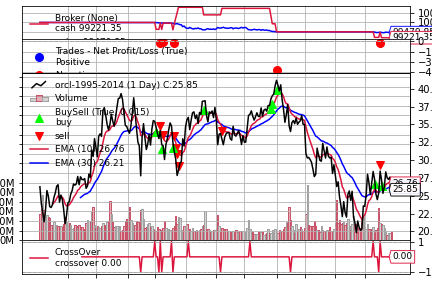

[[<Figure size 432x288 with 5 Axes>]]

In [10]:
cerebro.plot()
#Observe that a lot more green and red markers for buying and selling respectively
#Even at the points where there is no crossover whatsoever, and looks like the buy and sell signs are executed also

In [13]:
#The analysing ratios and graphs
#Get the first strategy, in backtrader the analysing is done for each individual sttrategy
strat = strats[0]

#Pyfolio is the default name given by backtrader, check how to give a custom name
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

pf.create_full_tear_sheet(
    returns,
    live_start_date=datetime.datetime(2000,1,3))


IndexError: index -1 is out of bounds for axis 0 with size 0